# Notebook compiling small circle fit functions to points and poles on sphere

## import pakcages

In [81]:
import numpy as np
import pandas as pd

from numpy.linalg import inv, solve

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit

import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_formats = {'svg',}

## define functions and wrapping up functions

In [2]:
def decompose_XY(matrix):
    matrix = np.array(matrix)
    X = matrix[:, [0,1]]
    Y = matrix[:, 2]
    return X, Y

def get_ortho_fitting_plane_vector(coords):

    # Calculate the covariance matrix of the coordinates
    covariance_matrix = np.cov(coords, rowvar=False) # Variables = columns

    # Calculate the eigenvalues & eigenvectors of the covariance matrix
    e_val, e_vect = np.linalg.eig(covariance_matrix)

    # The normal vector to the plane is the eigenvector associated to the minimum eigenvalue
    min_eval = np.argmin(e_val)
    normal_vector = e_vect[:, min_eval]

    return normal_vector

def least_squares_by_solve(X, Y):
    return solve(X.T @ X, X.T @ Y)

def add_ones_column(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def model_force_origin(X, Y):
    # this function forces the result to be a plane passing through the origin 
    # the result circle will be a great circle
    
    theta_hat = least_sqaures_by_solve(X, Y)
    return X @ theta_hat

def model_append_ones(X, Y):
    # this function returns a plane parameters of best fit to the data
    # the return values match (D, A, B)
    X_append_ones = add_ones_column(X)
    theta_hat = least_squares_by_solve(X_append_ones, Y)
    return X_append_ones @ theta_hat

def get_rho(A, B, C, D):
    # plane equation in form of Ax+By+Cz = D
    return -D/np.sqrt(A**2+B**2+C**2)

def get_circle_center(A, B, C, D):
    # plane equation in form of Ax+By+Cz = D
    rho = get_rho(A, B, C, D)
    center = rho/np.sqrt(A**2+B**2+C**2)*np.array([A, B, C])
    return center

def make_small_circle(rho, k):
    lon = np.linspace(0, 2*np.pi, 100)
    lat = (np.arctan(k*np.sin(lon))-np.arcsin(rho*np.sqrt(1+k**2)/(1+(k*np.sin(lon))**2)))*180/np.pi
    lon = lon*180/np.pi
    
    lon_lat = np.array([lon, lat]).T
    lon_lat_cart = pmag.dir2cart(lon_lat)
    
    return lon_lat_cart
    
def rodrigues_rot(P, n0, n1):
    # rotate a series of points given a rotation defined by starting vector n0 and ending vector n1
    
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[np.newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/np.linalg.norm(n0)
    n1 = n1/np.linalg.norm(n1)
    k = np.cross(n0,n1)
    k = k/np.linalg.norm(k)
    theta = np.arccos(np.dot(n0,n1))
    
    # Compute rotated points
    P_rot = np.zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*np.cos(theta) + np.cross(k,P[i])*np.sin(theta) + k*np.dot(k,P[i])*(1-np.cos(theta))

    return P_rot

def kappa_from_alpha95(alpha95):
    return 140. * 140. / alpha95 / alpha95

In [37]:
@jit
def fit_small_circle(points, intercept = True, return_dir = True):
    
    X, Y = decompose_XY(points)
    if intercept == True:
        
        theta_hat = least_squares_by_solve(add_ones_column(X), Y) # do plane fit with intercept
        D, A, B, C = theta_hat[0], theta_hat[1], theta_hat[2], -1
    else: 
        theta_hat = least_squares_by_solve(X, Y) # do plane fit without intercept (anchor at origin)
        D, A, B, C = 0, theta_hat[0], theta_hat[1], -1

    rho = get_rho(A, B, C, D)
    circle_center = get_circle_center(A, B, C, D)
    circle_center_lon_lat = pmag.cart2dir(circle_center)
    
    initial_circle_cart = make_small_circle(rho, 0)
    rotated_circle_cart = rodrigues_rot(initial_circle_cart, np.array([0,0,1]), circle_center)

    rotated_circle_dir = pmag.cart2dir(rotated_circle_cart)

    rotated_circle_lon, rotated_circle_lat = rotated_circle_dir.T[0], rotated_circle_dir.T[1]
    
    if return_dir == True:
        return [rotated_circle_lon, rotated_circle_lat], circle_center_lon_lat
    else:
        return rotated_circle_cart
    
@jit    
def fit_small_circle_by_ortho(points, intercept = True, return_dir = True):

    ABC = get_ortho_fitting_plane_vector(points)
    A, B, C = ABC[0], ABC[1], ABC[2]
    P_bar = np.mean(points, axis=0)
    D = np.dot(-P_bar, ABC)
    
    rho = get_rho(A, B, C, D)
    circle_center = get_circle_center(A, B, C, D)
    circle_center_lon_lat = pmag.cart2dir(circle_center)
    
    initial_circle_cart = make_small_circle(rho, 0)
    rotated_circle_cart = rodrigues_rot(initial_circle_cart, np.array([0,0,1]), circle_center)

    rotated_circle_dir = pmag.cart2dir(rotated_circle_cart)

    rotated_circle_lon, rotated_circle_lat = rotated_circle_dir.T[0], rotated_circle_dir.T[1]
    
    if return_dir == True:
        return [rotated_circle_lon, rotated_circle_lat], circle_center_lon_lat
    else:
        return rotated_circle_cart

@jit
def fit_poles(poles, fit_model, n=1000):
    '''
    poles should be in form of a list [[lon, lat, A95], [lon_1, lat_1, A95_1]....]
    fit_model should be one of the fitting functions above
    n should be a large enough number to sample from the fisher distributed poles for the fits 
    '''
    
    # first convert A95 into k
    poles = np.array(poles)
    poles_lon_lat = poles[:, [0,1]] # array of pole lons and lats
    poles_A95 = poles[:, [2]] # array of pole a95 angles
    poles_k = kappa_from_alpha95(poles_A95) # convert a95 to k values
    
#     print(poles, poles_lon_lat, poles_A95, poles_k)
    # draw n samples from each pole 
    pole_pool = []
    
    for i in range(len(poles_lon_lat)):
        ith_pole_draw = ipmag.fishrot(dec=poles_lon_lat[i][0], inc=poles_lon_lat[i][1], k=poles_k[i], n=n, di_block = True)
        
        pole_pool.append(pmag.dir2cart(ith_pole_draw))
    
    pole_group = []
    for j in range(n):
        jth_pole_group = []
        for k in range(len(poles)):
            jth_pole_group.append(pole_pool[k][j])
        pole_group.append(jth_pole_group)
        
#     print(pole_group)
    
    small_circle_poles = []
    for m in range(len(pole_group)):
        _, circle_center_lon_lat = fit_small_circle_by_ortho(np.array(pole_group[m]))
        small_circle_poles.append(circle_center_lon_lat)
    
    return pole_group, small_circle_poles

## initialize a synthetic model

In [38]:
test_poles = [[0, 30, 5], [20, 30, 5], [40, 30, 5], [60, 30, 5], [80, 30, 5]]


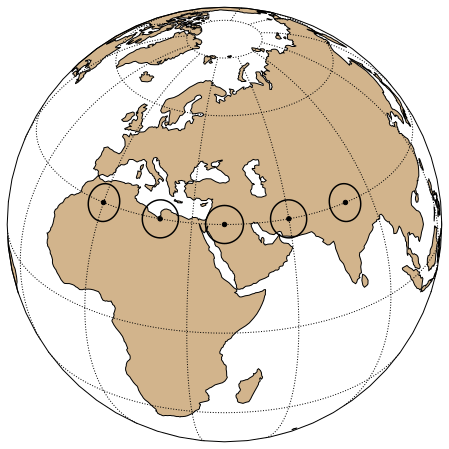

In [39]:
m = ipmag.make_orthographic_map(central_latitude=30,central_longitude=40)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

for i in range(len(test_poles)):
    ipmag.plot_pole(m, test_poles[i][0], test_poles[i][1], test_poles[i][2])

plt.show()

## make fits

In [68]:
pole_group, fitted_small_circle_poles = fit_poles(test_poles, fit_small_circle_by_ortho, n=5000)

In [69]:
print(pmag.cart2dir(pole_group[0]))

[[358.52486543  30.2898441    1.        ]
 [ 17.81728036  27.75018547   1.        ]
 [ 42.42580566  31.00965214   1.        ]
 [ 61.42031358  32.35898756   1.        ]
 [ 78.38576621  32.95430353   1.        ]]


In [70]:
m = ipmag.make_orthographic_map(central_latitude=45,central_longitude=40)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, di_block=fitted_small_circle_poles, color='blue', edge='none', markersize = 5)

for i in range(100):
    ipmag.plot_vgp(m, di_block=list(pmag.cart2dir(pole_group[i])), color='blue', edge='none', markersize = 5)
# m.scatter(di_block=fitted_small_circle_poles, color='blue', alpha=0.02, transform=ccrs.Geodetic(), label = 'orthofit')

plt.show()

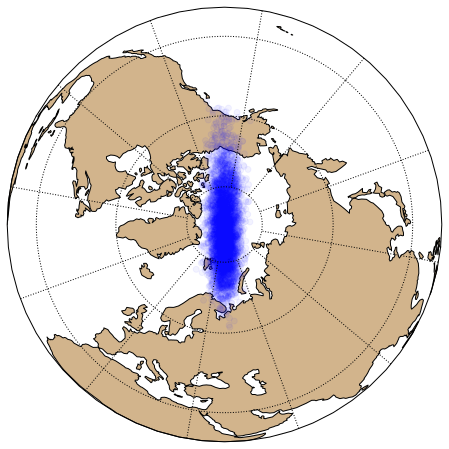

In [72]:
m = ipmag.make_orthographic_map(central_latitude=90,central_longitude=40)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

# ipmag.plot_vgp(m, di_block=fitted_small_circle_poles, color='blue', edge='none', markersize = 5)

# for i in range(100):
#     ipmag.plot_vgp(m, di_block=list(pmag.cart2dir(pole_group[i])), color='blue', edge='none', markersize = 5)
m.scatter(np.array(fitted_small_circle_poles).T[0], np.array(fitted_small_circle_poles).T[1], color='blue', alpha=0.05, transform=ccrs.Geodetic(), label = 'orthofit')

plt.show()

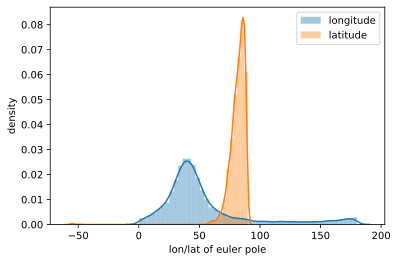

In [79]:
sns.distplot(np.mod(np.array(fitted_small_circle_poles).T[0], 180), label='longitude')
sns.distplot(np.array(fitted_small_circle_poles).T[1], label='latitude')

plt.xlabel('lon/lat of euler pole')
plt.ylabel('density')

plt.legend()
plt.show()

## testing with 2019 keweenawan APWP poles from the volcancis and sediments

In [87]:
kewee_2019_data = pd.read_csv('pole_means.csv')[['PLon', 'PLat', 'A95']]
kewee_2019_data

PLon  PLat  A95
0   218.6  40.9  4.8
1   203.4  42.3  3.7
2   227.0  49.5  5.3
3   205.2  37.5  4.5
4   189.7  36.1  4.9
5   183.2  31.2  2.5
6   201.7  46.0  6.8
7   181.7  31.1  4.2
8   179.3  36.9  2.1
9   187.6  28.3  2.5
10  182.5  27.5  2.3
11  180.8  22.2  4.5
12  214.0  45.8  9.2
13  174.7  17.0  4.4
14  178.1   7.6  5.6
15  179.0   2.2  4.2

In [92]:
kewee_pole_group, kewee_fitted_small_circle_poles = fit_poles(kewee_2019_data.to_numpy(), fit_small_circle_by_ortho, n=2000)

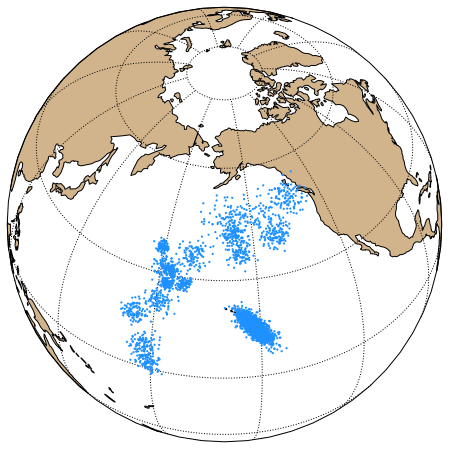

In [96]:
m = ipmag.make_orthographic_map(central_latitude=45,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, di_block=kewee_fitted_small_circle_poles, color='dodgerblue', edge='none', markersize = 5)

for i in range(100):
    ipmag.plot_vgp(m, di_block=list(pmag.cart2dir(kewee_pole_group[i])), color='dodgerblue', edge='none', markersize = 5)
# m.scatter(di_block=fitted_small_circle_poles, color='blue', alpha=0.02, transform=ccrs.Geodetic(), label = 'orthofit')

plt.show()

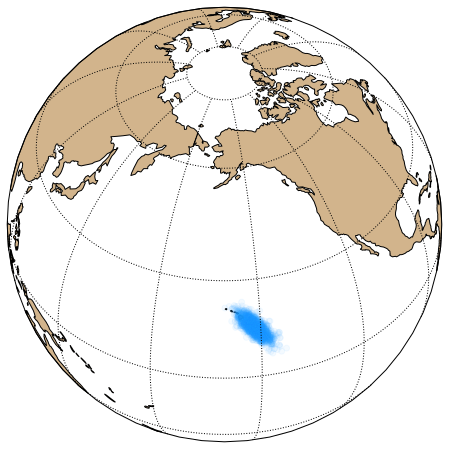

In [99]:
m = ipmag.make_orthographic_map(central_latitude=45,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

# ipmag.plot_vgp(m, di_block=fitted_small_circle_poles, color='blue', edge='none', markersize = 5)

# for i in range(100):
#     ipmag.plot_vgp(m, di_block=list(pmag.cart2dir(pole_group[i])), color='blue', edge='none', markersize = 5)
m.scatter(np.array(kewee_fitted_small_circle_poles).T[0], np.array(kewee_fitted_small_circle_poles).T[1], color='dodgerblue', alpha=0.05, transform=ccrs.Geodetic(), label = 'orthofit')

plt.show()

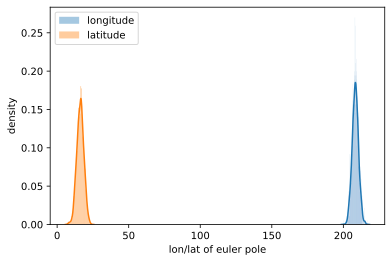

In [101]:
sns.distplot(np.array(kewee_fitted_small_circle_poles).T[0], 180, label='longitude')
sns.distplot(np.array(kewee_fitted_small_circle_poles).T[1], label='latitude')

plt.xlabel('lon/lat of euler pole')
plt.ylabel('density')

plt.legend()
plt.show()

In [ ]:
test_points_cart = [[-0.55159741, -0.43372721,  0.71247526],
       [-0.64362387, -0.30302385,  0.70279789],
       [-0.73624319, -0.18267434,  0.65159501],
       [-0.82279495, -0.0813267 ,  0.5624895 ],
       [-0.89705598, -0.0062657 ,  0.44187251],
       [-0.95370923,  0.03713601,  0.2984286 ],
       [-0.9887372 ,  0.04581344,  0.14247762]]

test_points_dir = [[218.17836582860136, 45.436667881756094, 1.0],
 [205.21147375219536, 44.651912049918934, 1.0],
 [193.93464904287293, 40.6619669281571, 1.0],
 [185.64489410721006, 34.228138976924356, 1.0],
 [180.40018938628526, 26.223415627688876, 1.0],
 [177.77011452295022, 17.363245620299324, 1.0],
 [177.34707988182242, 8.191240879546955, 1.0]]

In [ ]:
plane_normal = get_ortho_fitting_plane_vector(test_points_cart)
plane_normal

In [ ]:
X, Y = decompose_XY(test_points_cart)
least_squares_by_solve(add_ones_column(X), Y)

In [ ]:
P_bar = np.mean(test_points_cart, axis=0)
d = np.dot(-P_bar, plane_normal)
d

In [ ]:
plane_normal/-plane_normal[2]

In [ ]:
best_fit_circle, circle_center = fit_small_circle(test_points_cart)

In [ ]:
m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, di_block=test_points_dir)
ipmag.plot_vgp(m, circle_center[0], circle_center[1], color = 'r', markersize = 20)

m.plot(best_fit_circle[0], best_fit_circle[1],color='r', transform=ccrs.Geodetic(), alpha=0.5)

plt.show()

In [ ]:
ortho_best_fit_circle, ortho_circle_center = fit_small_circle_by_ortho(test_points_cart)

In [ ]:
m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, di_block=test_points_dir)
ipmag.plot_vgp(m, circle_center[0], circle_center[1], color = 'r', markersize = 60)
ipmag.plot_vgp(m, ortho_circle_center[0], ortho_circle_center[1], color = 'blue', markersize = 20)

m.plot(best_fit_circle[0], best_fit_circle[1],color='r', transform=ccrs.Geodetic(), alpha=0.5, label = 'least z fit')
m.plot(ortho_best_fit_circle[0], ortho_best_fit_circle[1], color='blue', transform=ccrs.Geodetic(), alpha=0.5, label = 'orthofit')

plt.legend()
plt.show()

In [ ]:
k = 50

dec, inc = ipmag.fishrot(dec=circle_center[0], inc=circle_center[1], k=k, n=100, di_block = False)

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)

plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, dec, inc)


# plt.legend()
plt.show()